In [9]:
from layers import ConvLayer, PoolLayer, DenseLayer, DetectorLayer, FlattenLayer
from mycnn import MyCNN
from PIL import Image
from sklearn.model_selection import train_test_split, KFold
from matplotlib import pyplot as plt
from sklearn import metrics
from copy import deepcopy
import numpy as np
import cv2
import os

In [2]:
# function to read image to numpy array
def read_dataset(dataset_path):
    """
    parameter:
    (a) dataset_path: path of the dataset [type: string]
    
    this function will return:
    (1) file_path: full path of each image file [type: 1D numpy array]
    (2) class_label: class of each image file, in numerical value 
                     [type: 1D numpy array]
    (3) class_dictionary: key(string) -> value (string), where 'key' is from (2) 
        and 'value' is from 'folder_name' [type: dictionary]
    """
    list_folder_per_kelas = os.listdir(dataset_path)
    list_folder_per_kelas = sorted(list_folder_per_kelas)
    file_path = []; class_label = np.ndarray(shape=(0)); class_dictionary = {}
    
    for i in range(len(list_folder_per_kelas)):#loop for all class folders
        class_folder_path = os.path.join(dataset_path, list_folder_per_kelas[i])
        list_image_name = os.listdir(class_folder_path)
        list_image_name = sorted(list_image_name)
        temp_file_path = [os.path.join(class_folder_path, j) for j in list_image_name]
        file_path += temp_file_path
        temp_class_label = np.full((len(list_image_name)),np.int16(i))
        class_label = np.concatenate((class_label, temp_class_label), axis=0)
        class_dictionary[str(i)] = list_folder_per_kelas[i]
    return np.asarray(file_path), class_label, class_dictionary

In [3]:
def apply_zeropadding(img_path, size=(100, 100)):
    '''
    parameter:
    a. img_path: file_path, which is 1D numpy array of all image file paths 
                 in the "Given Basic Code".
    b. size: tupple of desired image sizes after zero padding, 
             which is (height, width). In this hands-on week, 
             use the default value of (100, 100).

    return:
    a. prepocessed_images = 4D numpy array with the size of 
                            (150,  desired_height, desired_width, 3).
    HINT: use "cv2.resize()" API so that the longer dimension becomes 100,
           then, pad the shorter dimension with zero intensity values.

    Tasks:
    a. prepocessed_images is in RGB format
    b. Please show first-two prepocessed_images with their sizes. 
       Make sure that both sizes are same.
    '''
    prepocessed_images = []
    for file in img_path:
        img = cv2.imread(file, 1)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        height = img.shape[0]
        width = img.shape[1]
        desired_height, desired_width = size
        if (desired_height/desired_width > height/width):
            # Resize image based on its width and apply padding only to its height
            resize_ratio = desired_width/width
            resized_dim = (desired_width, int(height * resize_ratio))
            img_resized = cv2.resize(img, resized_dim)
            
            # Use floor and ceil in case we have desired height of an odd number
            top_pad = np.floor((desired_height - img_resized.shape[0]) / 2).astype(np.uint16)
            bottom_pad = np.ceil((desired_height - img_resized.shape[0]) / 2).astype(np.uint16)
            img_final = np.copy(np.pad(img_resized, ((top_pad, bottom_pad), (0, 0), (0, 0)), mode='constant', constant_values=0))
            
        elif (desired_height/desired_width < height/width):
            # Resize image based on its height and apply padding only to its width
            resize_ratio = desired_height/height
            resized_dim = (int(width * resize_ratio), desired_height)
            img_resized = cv2.resize(img, resized_dim)

            # Use floor and ceil in case we have desired width of an odd number
            left_pad = np.floor((desired_width - img_resized.shape[1]) / 2).astype(np.uint16)
            right_pad = np.ceil((desired_width - img_resized.shape[1]) / 2).astype(np.uint16)
            img_final = np.copy(np.pad(img_resized, ((0, 0), (left_pad, right_pad), (0, 0)), mode='constant', constant_values=0))
        else:
            # Do not apply padding
            img_final = cv2.resize(img, size)
        
        img_final = np.array(img_final)
        prepocessed_images.append(img_final)
    
    prepocessed_images = np.array(prepocessed_images)
    return prepocessed_images

In [4]:
def show_image(img, grey=False):
    if grey:
        plt.imshow(img, cmap='gray')
    else:
        plt.imshow(img)
    plt.show()
    print("img.shape:", img.shape)

## Baca dataset

In [5]:
dataset_path = "./dataset"
file_path, class_label, class_dictionary = read_dataset(dataset_path)
print("file_path:\n", file_path[0:4], ", shape:", file_path.shape)
print("\nclass_label:\n", class_label[0:4], ", shape:", class_label.shape)
print("\nclass_dictionary:\n", class_dictionary)

file_path:
 ['./dataset/cats/cat.0.jpg' './dataset/cats/cat.15.jpg'
 './dataset/cats/cat.17.jpg' './dataset/cats/cat.19.jpg'] , shape: (40,)

class_label:
 [0. 0. 0. 0.] , shape: (40,)

class_dictionary:
 {'0': 'cats', '1': 'dogs'}


## Image preprocessing
Prepocess image dengan menyamakan ukuran dan menambah padding zero, kemudian print 2 image pertama

prepocessed_images.shape: (40, 100, 100, 3)


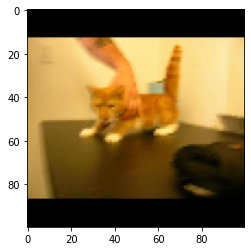

img.shape: (100, 100, 3)


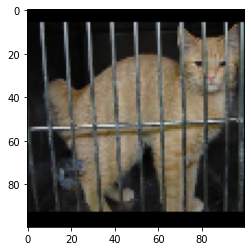

img.shape: (100, 100, 3)


In [10]:
prepocessed_images = apply_zeropadding(file_path)
print("prepocessed_images.shape:", prepocessed_images.shape)
show_image(prepocessed_images[0])
show_image(prepocessed_images[1])

In [11]:
# Transpose image to proper dimensions
prepocessed_images = np.transpose(prepocessed_images, (0,3,1,2))
print("prepocessed_images.shape after transpose:", prepocessed_images.shape)

prepocessed_images.shape after transpose: (40, 3, 100, 100)


## Training Step

### Using train test split 90%-10%

In [12]:
# Train-test split 90%-10%
X_train, X_test, y_train, y_test = train_test_split(prepocessed_images, class_label, test_size=0.1)

In [13]:
cnn = MyCNN (
    ConvLayer(filter_size=3,num_filter=3,num_channel=3),
    DetectorLayer(),
    PoolLayer(filter_size=3,stride_size=4,mode="Max"),
    ConvLayer(filter_size=3,num_filter=3,num_channel=3),
    DetectorLayer(),
    PoolLayer(filter_size=3,stride_size=1,mode="Max"),
    FlattenLayer(),
    DenseLayer(n_units=500, activation='relu'),
    DenseLayer(n_units=20, activation='relu'),
    DenseLayer(n_units=1, activation='sigmoid'),
)

In [14]:
cnn.fit(
    features=X_train,
    target=y_train,
    batch_size=5,
    epochs=10,
    learning_rate=0.1,
    momentum=0.5
)

Epoch: 1, Loss:  0.1, Accuracy:  0.8
Epoch: 2, Loss:  0.1253583027153496, Accuracy:  0.5
Epoch: 3, Loss:  0.1230200489165146, Accuracy:  0.6
Epoch: 4, Loss:  0.12387872080620636, Accuracy:  0.6
Epoch: 5, Loss:  0.12420389526526394, Accuracy:  0.6
Epoch: 6, Loss:  0.1230964659919431, Accuracy:  0.6333333333333333
Epoch: 7, Loss:  0.12138836757081906, Accuracy:  0.6571428571428571
Epoch: 8, Loss:  0.12370134430827687, Accuracy:  0.65
Epoch: 9, Loss:  0.12274286860326633, Accuracy:  0.6666666666666666
Epoch: 10, 

/home/ardyh/Documents/IF/MLL/IF4074_Tugas1/layers.py:47: RuntimeWarning: overflow encountered in multiply
  self._inputs[:, w:w+self._filter_size, h:h+self._filter_size] * self._weights[f, :, :, :]) + self._bias[f]
/home/ardyh/Documents/IF/MLL/IF4074_Tugas1/layers.py:75: RuntimeWarning: overflow encountered in multiply
  dx[:,w:w+self._filter_size,h:h+self._filter_size]+=prev_errors[f,w,h]*self._weights[f,:,:,:]


Loss:  0.12163842091039892, Accuracy:  0.68


#### Save and load model

In [15]:
model_name = 'pretrained_model'
cnn.save_model(model_name)

In [16]:
cnn2 = MyCNN()
cnn2.load_model(model_name)

#### Predict using loaded model

In [17]:
out = np.array([])
for data in X_test:
    out = np.append(out, np.rint(cnn2.forward(data)))

#### Print accuracy and confusion matrix

In [18]:
print("\n\nPredicted:", out)
print("\n\nAccuracy:", metrics.accuracy_score(y_test, out))
print("\n\nConfusion matrix:\n", metrics.confusion_matrix(y_test, out))



Predicted: [1. 1. 1. 1.]


Accuracy: 0.5


Confusion matrix:
 [[0 2]
 [0 2]]


### Using K-Fold Cross Validation

In [ ]:
kf = KFold(n_splits=10)
best_accuracy = 0
best_model = None
for train_index, test_index in kf.split(prepocessed_images):
    X_train, X_test = prepocessed_images[train_index], prepocessed_images[test_index]
    y_train, y_test = class_label[train_index], class_label[test_index]

    cnn = MyCNN (
        ConvLayer(filter_size=3,num_filter=3,num_channel=3),
        DetectorLayer(),
        PoolLayer(filter_size=3,stride_size=2,mode="Max"),
        ConvLayer(filter_size=3,num_filter=3,num_channel=3),
        DetectorLayer(),
        PoolLayer(filter_size=3,stride_size=2,mode="Max"),
        FlattenLayer(),
        DenseLayer(n_units=500, activation='relu'),
        DenseLayer(n_units=20, activation='relu'),
        DenseLayer(n_units=1, activation='sigmoid'),
    )

    cnn.fit(
        features = X_train,
        target = y_train,
        batch_size = 5,
        epochs = 10,
        learning_rate = 0.1,
        momentum = 0.5
    )

    out = np.array([])
    for data in X_test:
        out = np.append(out, np.rint(cnn.forward(data)))

    accuracy = metrics.accuracy_score(y_test, out)
    print("\nAccuracy:", accuracy)
    print("Confusion matrix:\n", metrics.confusion_matrix(y_test, out))
    if accuracy > best_accuracy:
        best_model = deepcopy(cnn)
        best_accuracy = accuracy

In [ ]:
print('Best accuracy: ', best_accuracy)